In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import glob
from tqdm import tqdm

from PIL import Image, ImageOps
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shoeplotlib import plot_tsne
import seaborn as sns
from utils import resize

from models import extract_features, kmeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
# load metadata df
hyped_info_df = pd.read_csv(os.path.join('..','data','hyped_info_df.csv'))
non_hyped_info_df = pd.read_csv(os.path.join('..','data','non_hyped_info_df.csv'))

In [3]:
# normalize pixel intensities for pca/kmeans/tnse
non_hyped_shoes = [np.asarray(Image.open(img)) / 225.0 for img in non_hyped_info_df.path]
hyped_shoes = [np.asarray(Image.open(img)) / 225.0 for img in hyped_info_df.path]

In [4]:
# flatten the shoes tensors
all_shoes = np.stack(non_hyped_shoes + hyped_shoes)
flattened_shoes = all_shoes.reshape(all_shoes.shape[0],-1)
flattened_shoes_df = pd.DataFrame(flattened_shoes)

In [5]:
# clear memory
non_hyped_shoes, hyped_shoes = None, None
all_shoes = None

In [7]:
# hyped targets
flattened_shoes_df['hyped'] = 0
for i in range(flattened_shoes_df.shape[0]):
    flattened_shoes_df['hyped'].iloc[i] = i > len(non_hyped_info_df) - 1

In [13]:
# sanity check
flattened_shoes_df['hyped'].loc[len(non_hyped_info_df)-1]

False

### TSNE

In [10]:
# tsne for all flattened sneaker vectors
tsne_aker = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne_aker.fit_transform(flattened_shoes_df.drop('hyped',axis=1).values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6758 samples in 311.727s...
[t-SNE] Computed neighbors for 6758 samples in 9890.907s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6758
[t-SNE] Computed conditional probabilities for sample 2000 / 6758
[t-SNE] Computed conditional probabilities for sample 3000 / 6758
[t-SNE] Computed conditional probabilities for sample 4000 / 6758
[t-SNE] Computed conditional probabilities for sample 5000 / 6758
[t-SNE] Computed conditional probabilities for sample 6000 / 6758
[t-SNE] Computed conditional probabilities for sample 6758 / 6758
[t-SNE] Mean sigma: 21.527314
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.407013
[t-SNE] KL divergence after 3000 iterations: 1.437225


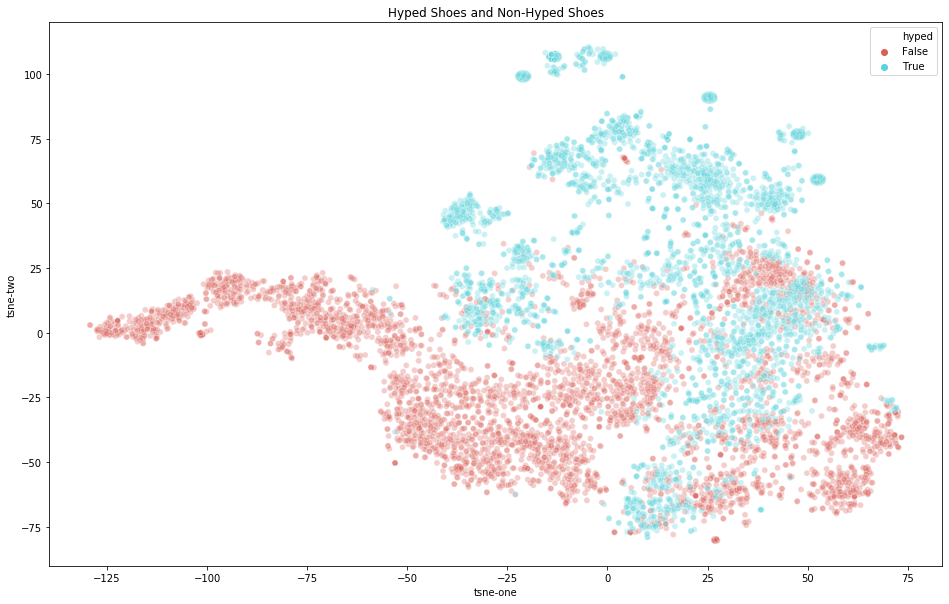

In [11]:
plot_tsne(tsne_results, non_hyped_info_df.shape[0])

In [17]:
# tsne for only hyped sneakers
hyped_only = [np.asarray(Image.open(img)).flatten() / 225.0 for img in hyped_info_df.path]
hyped_tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=3000)
hyped_results = hyped_tsne.fit_transform(hyped_only)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2913 samples in 179.992s...
[t-SNE] Computed neighbors for 2913 samples in 2463.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2913
[t-SNE] Computed conditional probabilities for sample 2000 / 2913
[t-SNE] Computed conditional probabilities for sample 2913 / 2913
[t-SNE] Mean sigma: 21.772755
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.695908
[t-SNE] KL divergence after 3000 iterations: 1.009372


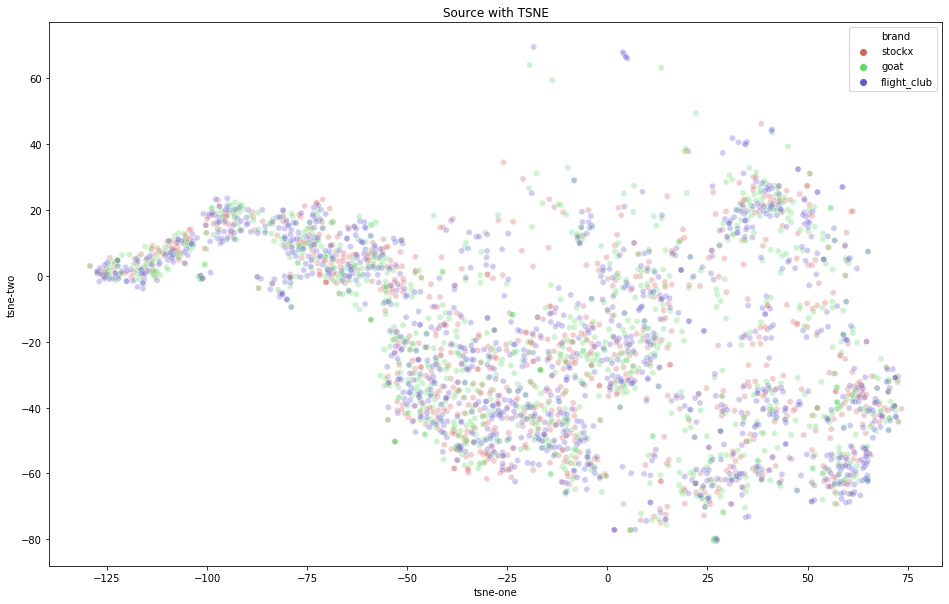

In [24]:
plot_tsne(tsne_results, hyped_info_df.source, 
          'other', classes=3,
          title='Source with TSNE')

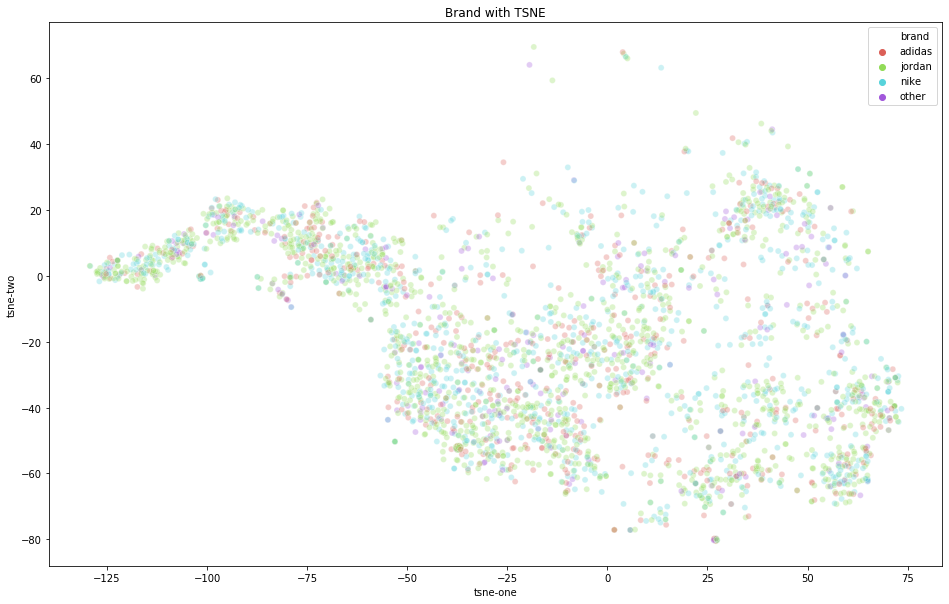

In [28]:
# tsne for only nike, adidas and jordans
most_hyped = hyped_info_df.brand.apply(lambda x: x if x in ['nike','adidas','jordan'] \
                                         else 'other')
plot_tsne(tsne_results, most_hyped, 
          'brand', classes=4,
          title='Brand with TSNE')

### PCA and KMeans

In [30]:
# grab flatten hyped shoe vectors
hyped_shoes = [np.asarray(Image.open(img)).flatten() / 255.0 for img in hyped_info_df.path]

In [31]:
# 80% variance for pca
shoes_pca = PCA(n_components=80)
hyped_pcs = shoes_pca.fit_transform(hyped_shoes)

In [32]:
sum(shoes_pca.explained_variance_ratio_)

0.8299235415348672

100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


For n_clusters = 2, silhouette score is 0.23020059972219842
For n_clusters = 3, silhouette score is 0.2261031138786737
For n_clusters = 4, silhouette score is 0.22385418716986313
For n_clusters = 5, silhouette score is 0.22470812704754045
For n_clusters = 6, silhouette score is 0.20027729072666411
For n_clusters = 7, silhouette score is 0.20919551883812396
For n_clusters = 8, silhouette score is 0.16998474275256092


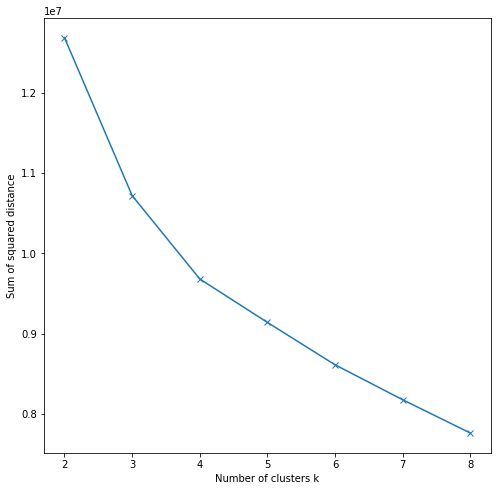

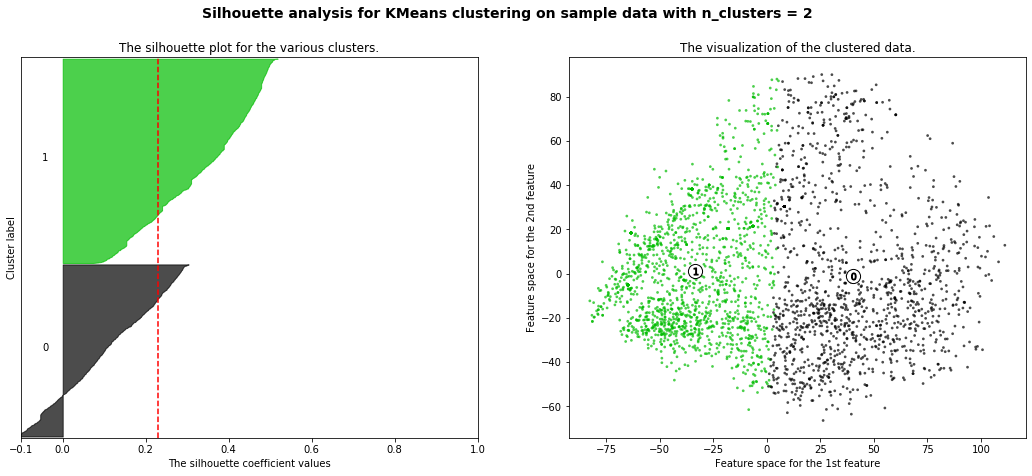

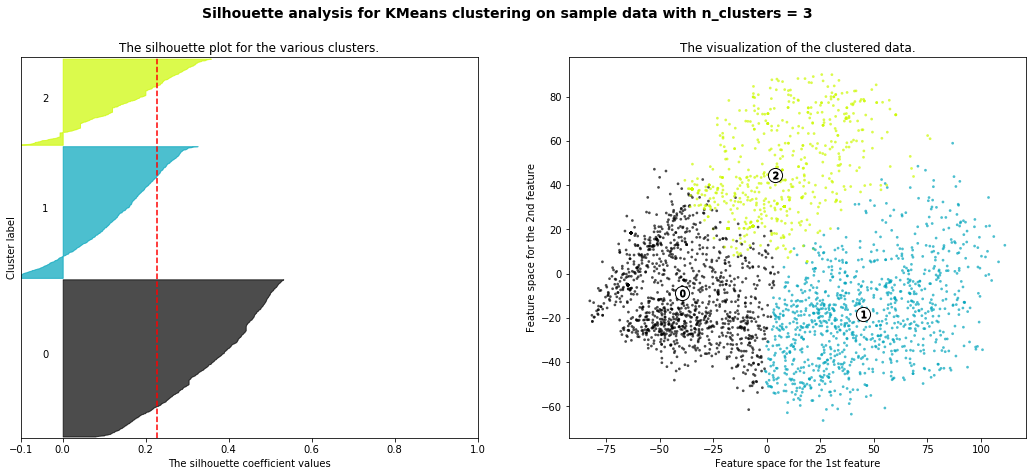

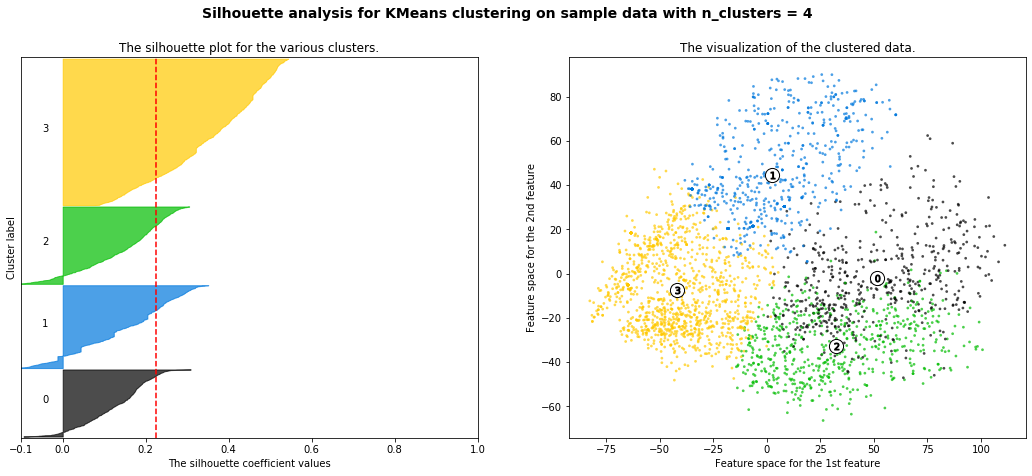

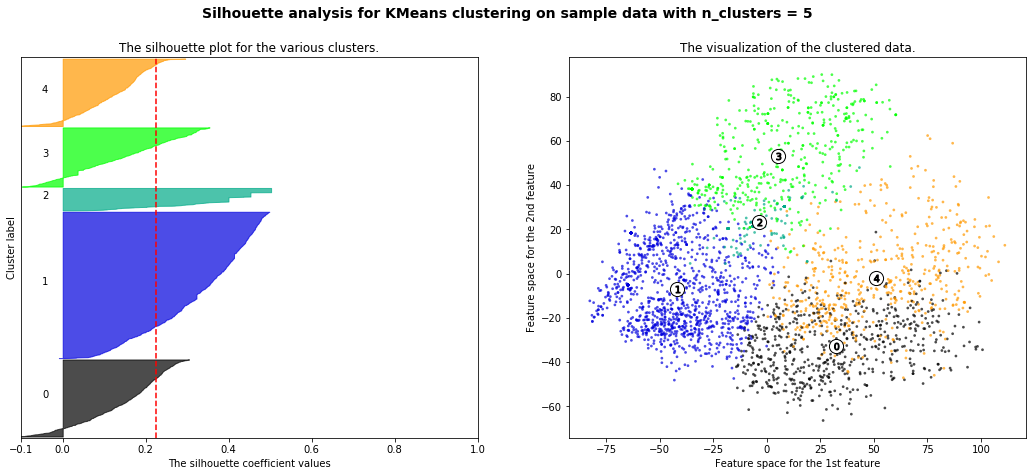

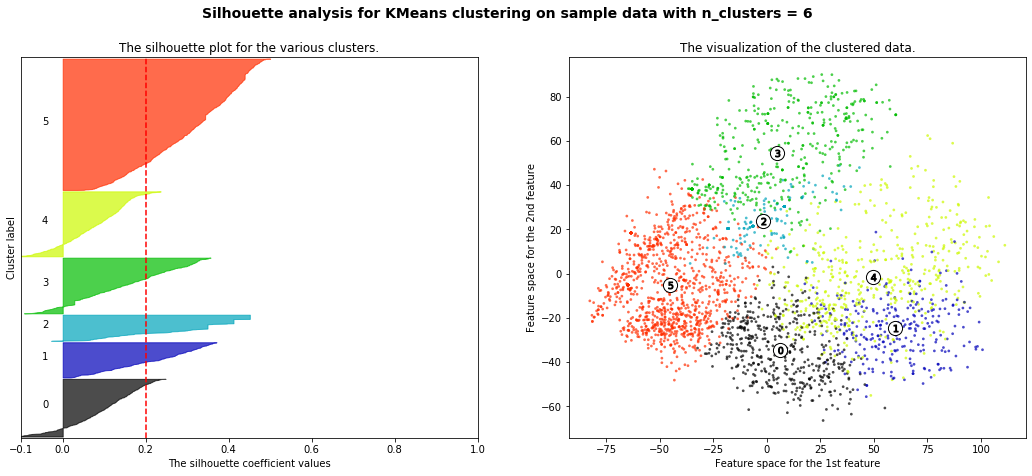

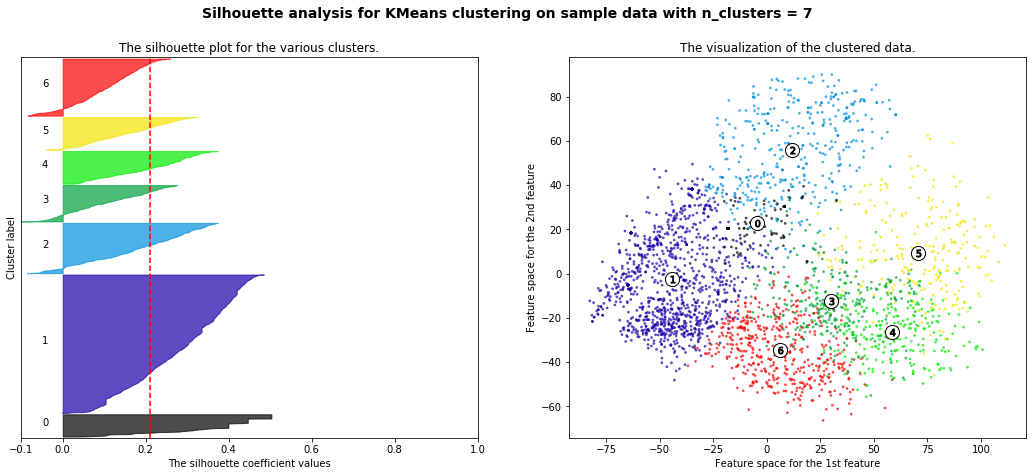

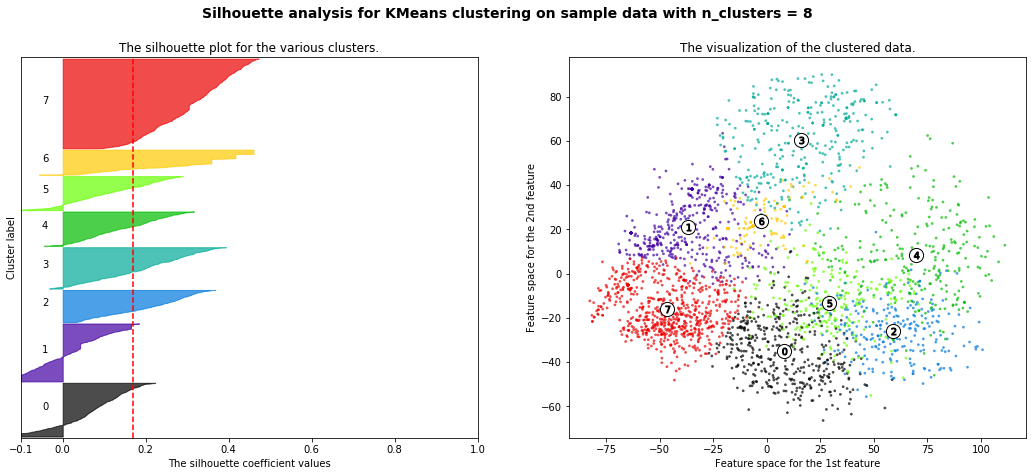

In [33]:
# kmeans from the first 80 pcs
k_shoes = kmeans(data=hyped_pcs)
k_shoes.draw_elbow()
k_shoes.calc_silhouette()
k_shoes.plot_silhouette()

In [34]:
# k=3 clusters
k_shoes_3 = KMeans(n_clusters=3, random_state=24).fit(hyped_pcs)
hyped_info_df['kmeans_3'] = k_shoes_3.labels_

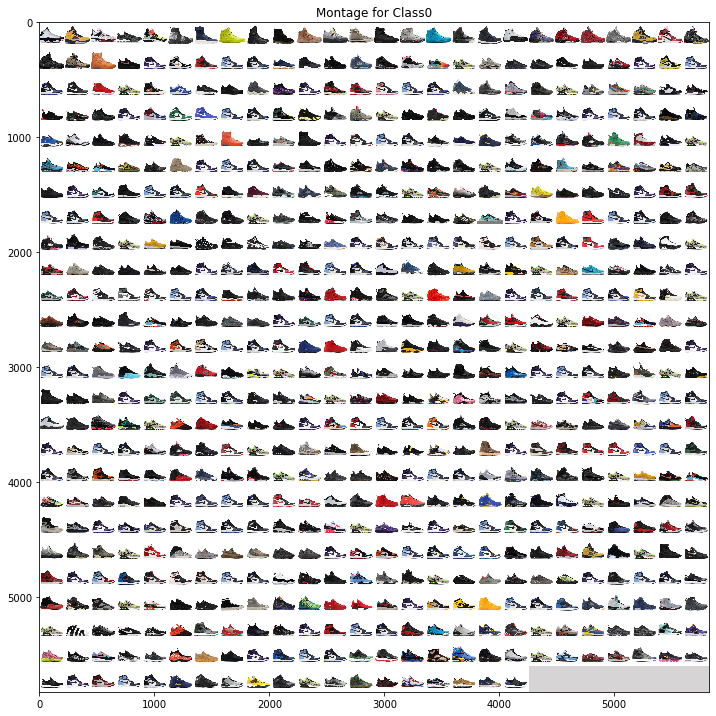

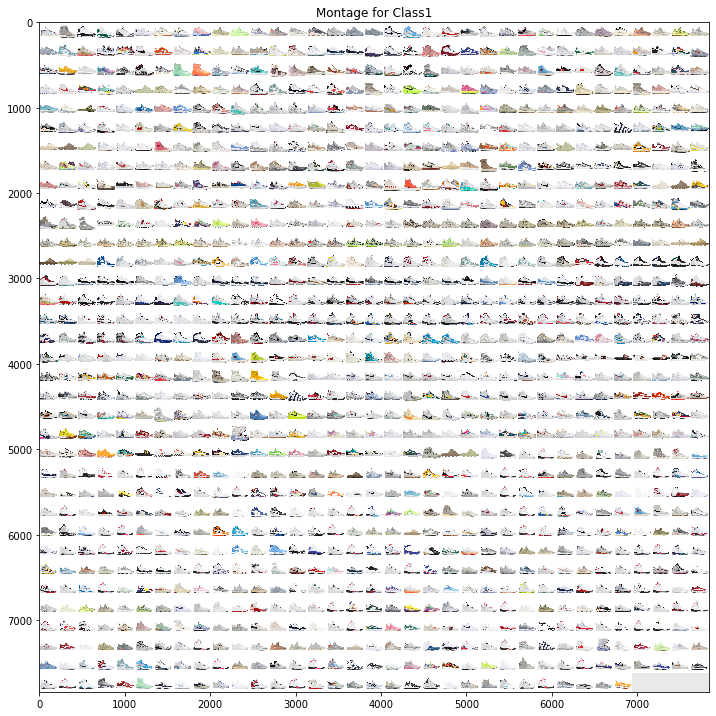

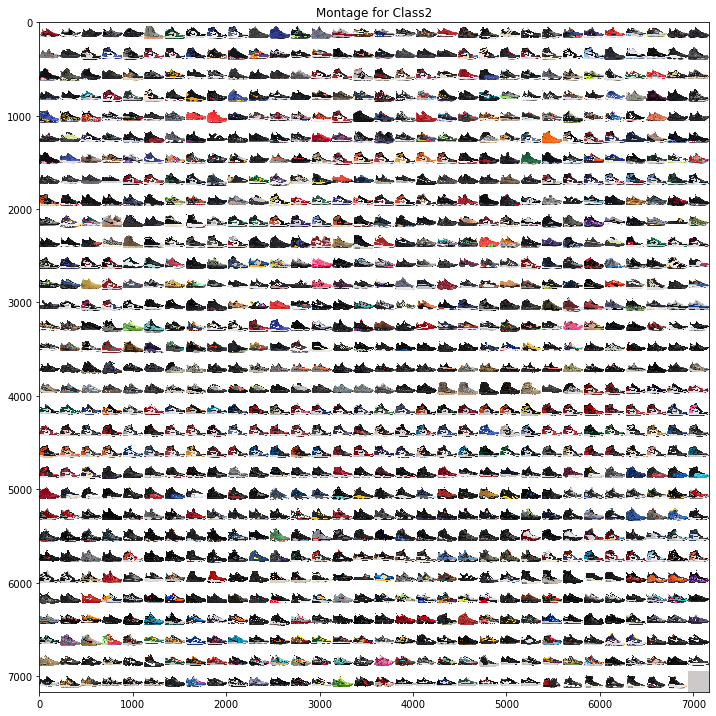

In [35]:
k_shoes.k_means_montage(hyped_info_df,'kmeans_3')

In [ ]:
# k=5 clusters
k_shoes_5 = KMeans(n_clusters=5, random_state=24).fit(hyped_pcs)
hyped_info_df['kmeans_5'] = k_shoes_5.labels_

In [ ]:
k_shoes.k_means_montage(hyped_info_df,'kmeans_5')

In [36]:
ben_jerry_dunks = Image.open('ben_jerry_dunks.jpg')
resized_dunks_img = resize(ben_jerry_dunks.copy(), (224,224))

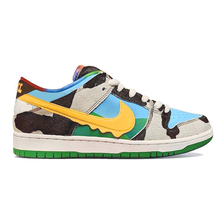

In [37]:
resized_dunks_img

In [38]:
# test out cluster for new shoe
resized_dunks_np = np.asarray(resized_dunks_img).flatten() / 255.0
pc_dunks = shoes_pca.transform([resized_dunks_np])
k_shoes_3.predict(pc_dunks)

array([1])

### Feature extraction from CNN Models

In [39]:
# extract features from vgg out
shoe_vgg_feats = extract_features(hyped_info_df.path,'vgg')

58892288/58889256 [==============================] - 21s 0us/step


100%|██████████| 2913/2913 [17:08<00:00,  2.83it/s]


In [40]:
tsne_aker = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=3000)
tsne_results = tsne_aker.fit_transform(shoe_vgg_feats)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2913 samples in 28.101s...
[t-SNE] Computed neighbors for 2913 samples in 654.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2913
[t-SNE] Computed conditional probabilities for sample 2000 / 2913
[t-SNE] Computed conditional probabilities for sample 2913 / 2913
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.353073
[t-SNE] KL divergence after 3000 iterations: 1.341929


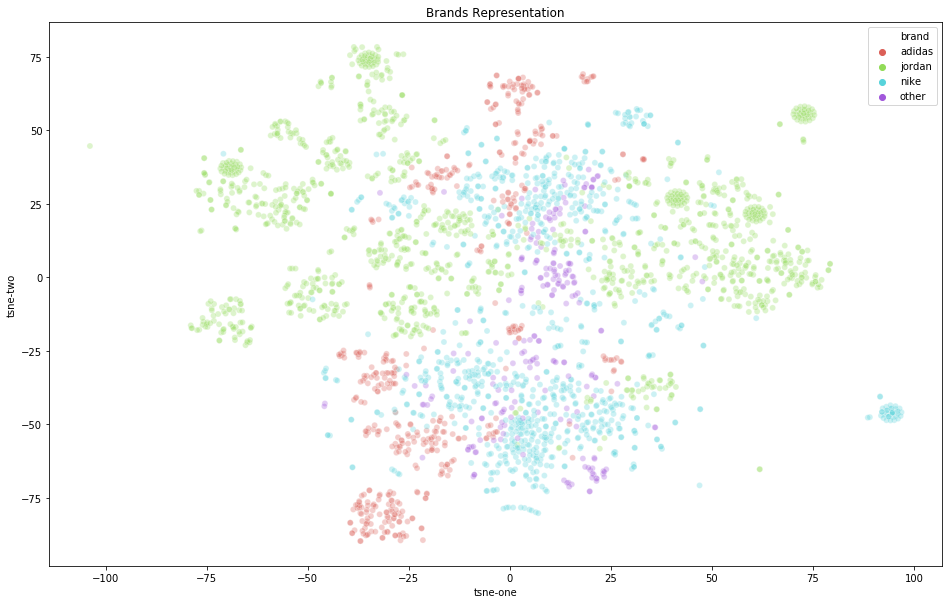

In [42]:
# tsne from vgg out
plot_tsne(tsne_results,most_hyped,'brand',
          classes=most_hyped.nunique(),title='Brands Representation')

In [3]:
# jordans, nike, adidas from resnet out
hyped_sub_df = hyped_info_df[hyped_info_df.brand.isin(['jordan','nike','adidas'])]
sub_res_feats = extract_features(hyped_sub_df.path,'res') # resnet w/o head
sub_tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000)
sub_tsne_results = sub_tsne.fit_transform(sub_res_feats)

94773248/94765736 [==============================] - 33s 0us/step


100%|██████████| 2695/2695 [10:26<00:00,  4.30it/s]


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 2695 samples in 3.033s...
[t-SNE] Computed neighbors for 2695 samples in 41.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2695
[t-SNE] Computed conditional probabilities for sample 2000 / 2695
[t-SNE] Computed conditional probabilities for sample 2695 / 2695
[t-SNE] Mean sigma: 7.406232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.540092
[t-SNE] KL divergence after 4800 iterations: 1.314507


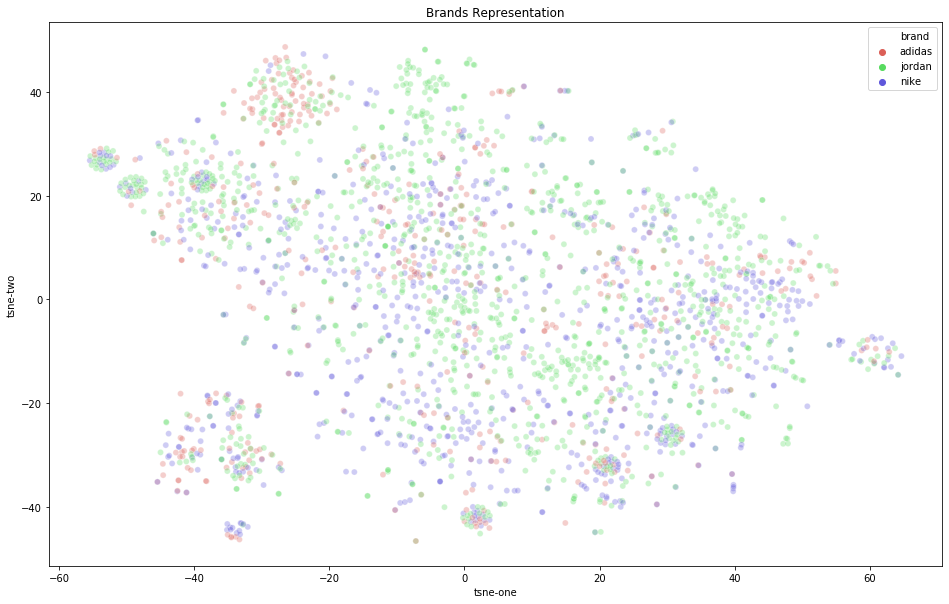

In [4]:
#tsne for jordans, nike and adidas from resnet out
plot_tsne(sub_tsne_results,hyped_sub_df.brand,'brand',
          classes=hyped_sub_df.brand.nunique(),title='Brands Representation')